<a href="https://colab.research.google.com/github/good0neighbour/ESTCampAI/blob/main/%EC%96%B8%EC%96%B4%EC%A7%80%EB%8A%A5(%ED%97%88%EA%B9%85%ED%8E%98%EC%9D%B4%EC%8A%A4_NLP)/ex01_HuggingFace_TransformersLibrary%EB%A7%9B%EB%B3%B4%EA%B8%B0(pipline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 런타임 > 유형 변경 > gpu
# -- cpu 대체 가능

# 드라이브 연동
%cd '/content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)'

/content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)


## 1. Transformer 등장 배경
- RNN 계열의 모델 단점:
  - 종류: simpleRNN, LSTM, GRU
  - 단점: 시퀀스를 처리할 때, 순차적으로 입력받아 처리하기 때문에 시간상으로 굉장히 느림, 장기 의존성 문제를 해결해야하는 문제 발생
    - 장기의존성 문제: 은닉층의 과거 정보가 마지막까지 전달되지 못하는 현상
    - LSTM, GRU 등장: 개선된 부분이 존재, 여전히 시간적인 문제 발생, 정보 소실이 있는 상황
    - 모델 자체적으로 문맥에 대한 이해력 부족->개선: 임베딩(수치화 작업)필요
> 2017년 구글 발표 (논문 **Attention is all you need**에서 나온 모델)
> - 기존의 seq2seq의 구조(LSTM 단위)인 **<U>인코더-디코더**</U>를 따르면서도, 논문의 이름처럼 **<U>어텐션(Attention)만으로 구현한 모델**</U>
>- 핵심 아이디어: 모든 단어 간 관계를 ‘Self-Attention’으로 한 번에 학습
> -  Attention이란 문맥에 따라 집중할 단어를 결정하는 방식을 의미
> - 장점:  
> 문장 전체를 한 번에 처리 (병렬처리 가능)  
> 문맥 이해력 향상  
> 대규모 사전학습(Pretraining)에 적합

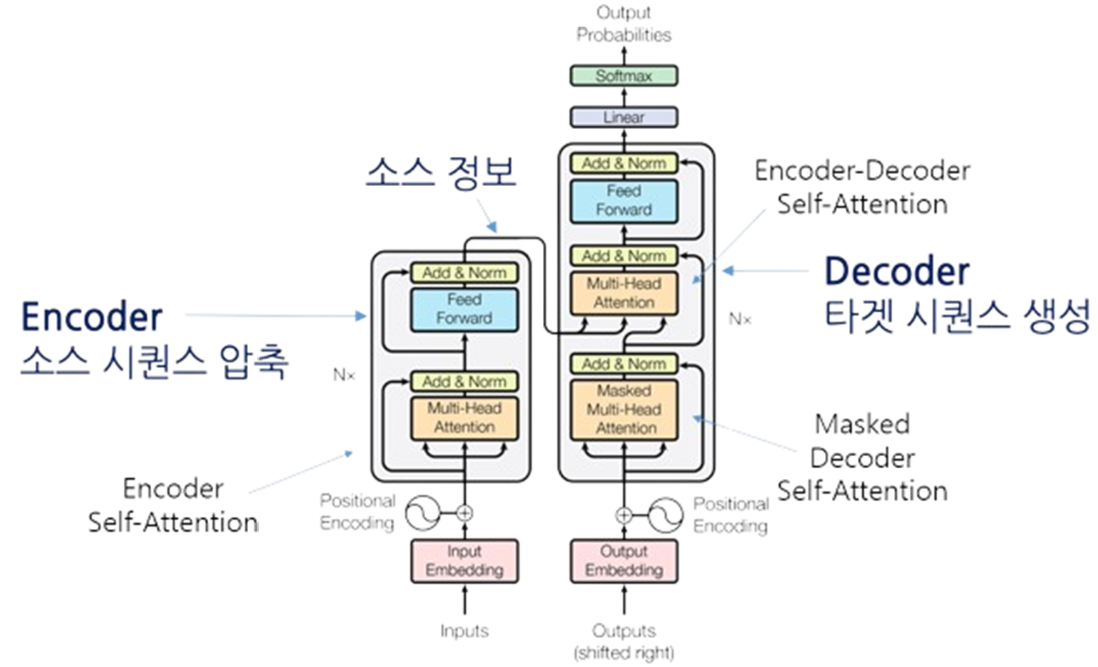

## 2. Transformer 구조

> **Positional Encoding (위치 인코딩)**
> - Self-Attention 기반 모델은 입력 순서를 순차적으로 처리하지 못 함
> - 이에 대해 **<U>토큰 간 순서 정보**</U>를 알려주기 위함 (한 문장을 병렬로 처리하면서도 각 단어의 위치를 인지하게 됨)

> **Encoder Self-Attention**
> - 인코더는 **<U>입력 문장의 모든 단어 간의 관계**</U>를 계산하여, 문장 전체에서 중요한 정보를 파악

> **Add & Norm**
> - 출력에 원래 입력을 **<U>더하고, 값을 정규화**</U>하여 안정된 학습을 도움
> - ResNet - Skip Connection 개념 차용

> **Feed Forward**
> - 활성화 함수(ReLU)를 사용해 입력을 처리해서, 비선형성을 통해 모델이 더 복잡한 패턴을 학습할 수 있게 만드는 **<U>완전 연결 신경망**</U> (쉽게 MLP 떠올리면 됨)

> **Masked Decoder Self-Attention**
> - 디코더가 예측할 때 미래 단어를 **<U>참조하지 못하게 막아**</U>, 이전 단어들만을 사용해 순차적으로 예측

> **Encoder-Decoder Self-Attention**
> - Seq2Seq Attention (Bahdanau/Luong)에서 발전된 형태
> - **<U>디코더가 인코더의 출력을 참조**</U>하여,  입력 문장과의 관계를 기반으로 더 정확한 출력을 생성

## Hugging Face_Transformers 라이브러리 설치하기

- **<U>Colab**</U> : 구글에서 제공하는 클라우드 컴퓨팅 서비스, 주피터 노트북을 기반으로 작동하며, GPU 자원을 무료로 일부 활용할 수 있음

- **<U>Hugging face**</U> : 인공지능 관련 데이터셋, 모델, 테스팅 공간 등을 공유하는 커뮤니티 웹서비스

In [ ]:
# torch : 옵션 개념, Pythorch 백앤드를 사용하는 모델을 위한 추가 패키지를 설치
# 기존 deeplearning: tensorflow 패키지
# hugging face: pytorch 패키지를 대부분 활용 중
!pip install transformers[torch]

In [ ]:
# version 버전 확인
!pip show transformers
# Version: 4.57.1

Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


## NLP Task 맛보기
- 허깅페이스: https://huggingface.co/models
- Tasks: 작업 단위
- Hugging Face Transformers Documents : https://huggingface.co/learn/llm-course/ko/chapter1/3?fw=pt

#### Transformer 종류
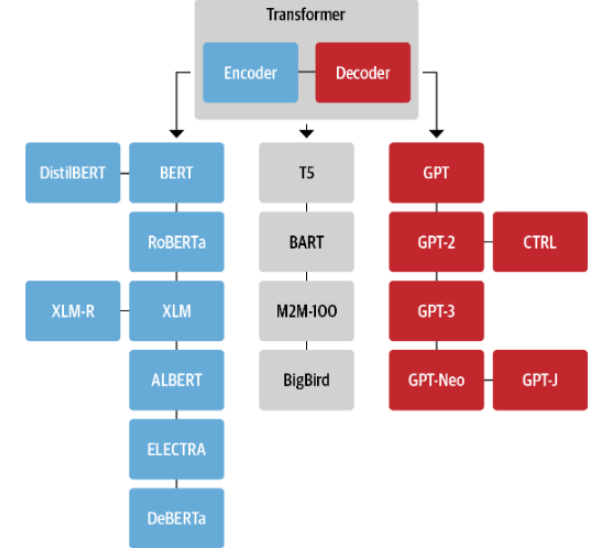

- 넓은 관점에서 트랜스포머 모델은 세 가지로 범주화 할 수 있음

> BERT 계열
> - Transformer 모델의 Encoder만 활용
> - 입력 전체를 한 번에 보고, 양방향으로 학습
> - 대표 모델 : BERT, ELECTRA 등
> - 주 사용처 : 문장 분류, 개체명 인식, 문장 유사도 등 전체 문장에 대한 이해를 요구하는 작업
>     - 빠른 추론과 가벼운 배포가 장점, 분류/검색/추천/임베딩 등 읽기 중심의 task에 많이 쓰임

> Seq2Seq 계열
> - Sequence-to-Sequence(Encoding → Decoding) 구조
> - 다양한 생성, 이해 작업에 강점을 가짐
> - 대표 모델 : T5, BART 등
> - 주 사용처 : 제로샷 분류, 요약/번역/재작성 등
>     - 다수 task(요약, 번역, 생성 등)을 하나의 모델로 운영 할 때 자주 사용

> GPT 계열
> - Transformer 모델의 Decoder만 활용
> - 입력을 순차적으로 처리하며 다음 토큰 예측(순방향)
> - 대표 모델 : GPT, GPT-2, CTRL, GPT-3, GPT-4 등
> - 주 사용처 : 텍스트 생성, 대화형 에이전트 등
>     - 창의적 생성이 장점, 프롬프트 엔지니어링이 중요할 때 선호

## Hugging Face 을 통한 Transformer 모델 사용하기

### 문제 상황(가상 사례)
- “세이프챗”은 월간 활성 사용자 **100만 명**을 보유한 글로벌 커뮤니티 플랫폼  
- 매일 평균 <u>**10,000건 이상의 게시글**</u>이 한국어·영어·스페인어 등 여러 언어로 등록되어 <u>수동 검토 불가</u>  
- 기존 RNN 계열 모델은 <u>**긴 시퀀스 처리 한계**</u>와 <u>**순차적 처리 병목**</u>로 인해 다국어 분류·번역 속도 저하  
- Transformer Pipeline을 통해
    - <u>**감성 분석**</u>: 악성 댓글. 공격적 언어 탐지 등
    - 감성분석에 <u>**다국어 자동번역**</u> : 언어 장벽 없이 동일한 정책으로 감정 분석,
    - <u>**제로샷 토픽 분류**</u>: 새로운 주제의 글도 자동으로 분류하여 모니터링 효율 극대화  
    \> Transformer 기반 파이프라인을 통합적으로 구성해야 한다는 과제가 정의됨

```python
# 주요 이해관계자
- 개발팀   : HuggingFace Pipeline 기반 API 설계·배포  
- 운영팀   : 실시간 모니터링 및 이상 징후 알림 시스템 운영  
- 콘텐츠팀 : 분류·번역 결과를 활용한 다국어 콘텐츠 관리 전략 수립
```

## 파이프라인
### 1. 감성분석(sentiment-analysis)
- text classification: 텍스트 분류, 텍스트를 입력 받고 어떤 종류의 범주에 속하는지 구분하는 작업
- 감성분석: 텍스트 내에서 사람의 기분, 감정, 의견(topic) 등을 예측하는 기술

In [ ]:
# pipelin 기능 불러오기
from transformers import pipeline

classifier = pipeline(task = "text-classification",                 # 작업 단위 지정
                model = "daekeun-ml/koelectra-small-v3-nsmc", # 사용할 사전학습 모델 경로 연결
                device = 0                                    # gpu 사용 (cpu:-1, gpu:0 0번째 장치 연결)
                )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/56.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# KoELECTRA
# - 한국어에 특화된 일렉트라 모델
# - 초기 BERT 모델에 비해 학습 효율(속도, 성능) 측면에서 유리하게 만들어진 모델
# https://huggingface.co/daekeun-ml/koelectra-small-v3-nsmc

In [ ]:
# 예측 수행
# 0: 부정
# 1: 긍정
classifier("넌 정말 좋은 사람이야.")
# label: 예측값(1) - 긍정
# score: 긍정에 대한 확신 정도(확률값) - 98%만큼 긍정 문장이라소 생각(예측, 추론)

[{'label': '1', 'score': 0.9884359836578369}]

In [ ]:
# 여러 문장 예측 수행
# [문장, 문장, 문장, ...]
classifier(["이 영화 정말 재밌어요.", "별로인데?", "연기 소름 돋아", "자~알 한다"])

# "자~알 한다"는 텍스트만 보면 긍정이지만,
# 부정적인 느낌의 문장이었기 때문에 해당 모델이 부정으로 잘 판단하고 있음을 알 수 있음
# 해당 모델의 성능이 꽤 좋음을 알 수 있음.

[{'label': '1', 'score': 0.9919895529747009},
 {'label': '0', 'score': 0.9993563294410706},
 {'label': '1', 'score': 0.9952178001403809},
 {'label': '0', 'score': 0.9448397159576416}]

### 2. 문장번역(translation)

In [ ]:
# Helsinki-NLP/opus-mt-ko-en

ko_to_en = pipeline(
    task = 'translation',
    model = 'Helsinki-NLP/opus-mt-ko-en',
    device = 0
)

# 100% 다운로드 되지 않아도 최소한의 자원으로 모델 실행
# 모델 실행이 되면서 나머지 부분도 다운
# UserWarning: Recommended: pip install sacremoses.
# warnings.warn("Recommended: pip install sacremoses.")
# -- sacremoses: 주로 텍스트를 처리하는 도구 (출력 품질 높임)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu


In [ ]:
ko_to_en("오늘도 보람찬 하루였습니다. 내일도 즐거운 마음으로 출근해야지.")

[{'translation_text': "It's been a rewarding day, and I'm happy to come to work tomorrow."}]

In [ ]:
print(ko_to_en("집에 가고 싶다. 6시 되면 칼퇴근 해야지"))
print(ko_to_en("집에 가고 싶다. 6시에 칼퇴근 해야지"))
print(ko_to_en("집에 가고 싶다 6시 되면 칼퇴근 해야지"))

# 칼퇴근이라는 단어는 한국에서만 사용 -> 문장의 형태에 따라서 번역이 될 때가 있고 안 될 때 있음(성능이 떨어짐)
# 신조어가 들어가게 되면, 표현되는 번역 문장의 의미가 미묘하게 바뀔 수 있음

[{'translation_text': 'I want to go home.'}]
[{'translation_text': 'I want to go home, get back to work at 6:00.'}]
[{'translation_text': "I want to go home. I'll be back to work by 6:00."}]


### 3.Zero-shot Classification(제로샷 분류)
- Zero-shot: 학습 0인 상태로 바로 분류에 적용하는 것
- 사전 훈련 된 NLI 모델(Natural Language Inference)을 이용해 새로운 라벨(클래스)에도 별도 학습 없이 분류를 수행하는 Task

> 텍스트에 레이블을 다는 것은 시간이 많이 소요되고 도메인 지식이 필요하기 때문에 이러한 작업은 실제 프로젝트에서 아주 흔한 상황
> - 입력 문장과 후보 라벨(프롬프트로 구성) 간의 연관성을 점수화 하여 가장 적합한 라벨 예측
> - 텍스트 마이닝(ex.추상적인 Topic을 발견)에서도 활용

> 장점
> - 학습 데이터가 없거나 부족한 도메인에서도 즉시 분류 가능
> - 유연하게 라벨을 추가/변경 할 수 있음

> 단점
> - NLI 모델이 다루지 못 하는 복잡한 Task는 성능 저하
> - 라벨 문장(Prompt) 설계에 따라 결과가 민감하게 변동됨

- xlm-roberta-large-xnli `BERT 계열` : 한국어 포함 총 100여 개 언어 지원, 가장 널리 쓰이는 제로샷 분류용 모델 중 하나
- 허깅페이스 링크 : https://huggingface.co/joeddav/xlm-roberta-large-xnli

In [ ]:
# 모델 로드
# task
# model
# 장치 gpu
classifier = pipeline(
    task = 'zero-shot-classification',
    model = 'joeddav/xlm-roberta-large-xnli',
    device = 0 # gpu
)

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


##### 파이프라인 Task 종류

| 파이프라인                      | 설명                                |
| -------------------------- | --------------------------------- |
| `feature-extraction`       | 특징 추출 (텍스트에 대한 벡터 표현 추출)          |
| `fill-mask`                | 마스크 채우기                           |
| `ner`                      | 개체명 인식 (Named Entity Recognition) |
| `question-answering`       | 질의 응답                             |
| `sentiment-analysis`       | 감정 분석                             |
| `summarization`            | 요약                                |
| `text-generation`          | 텍스트 생성                            |
| `translation`              | 번역                                |
| `zero-shot-classification` | 제로샷 분류 (레이블 분류)                   |

In [ ]:
# 분류할 문장 정의 (고객 리뷰)
sequences = [
    # 폭싹 속았수다(드라마) 리뷰
    """요즘 '폭싹속았수다' 보는 재미로 산다ㅠ 나 보는 거 엄마가 옆에서 보고는 아이유 연기 잘한다고 재밌게 보더니 나 없을 때 정주행하심ㅋㅋ""",

    # IT/과학기술 관련 뉴스 내용 일부분
    """30년간 인터넷은 ‘검색창에 단어를 입력하고 링크를 클릭하는’ 방식으로 탐색됐다. 그러나 생성형 인공지능(AI) 등장은 이 오래된 구조를 바꾸고 있다.
    마이크로소프트(MS), 오픈AI, 퍼플렉시티 등 주요 기술기업들이 잇따라 AI 브라우저를 내놓으며 웹의 첫 진입점,
    이른바 ‘인터넷 첫 화면’을 둘러싼 경쟁이 본격화됐다. 검색창 대신 AI 대화창이 그 자리를 대체하는 흐름이다."""
]

In [ ]:
# 후보 라벨(토픽) 목록 - zero shot
# 각 라벨(토픽)에 대한 설명 없이 해당 모델이 알아서
# 유사도가 높은 토픽으로 매칭하도록 목록만 제시
candidate_labels = ["드라마/영화", "정치", "IT/과학", "경제", "음식", "스포츠"]

In [ ]:
# 모델 실행 - 추론(예측)
# 제로샷 분류 수행
results = classifier(sequences,
                     candidate_labels,
                     multi_label = True)

results

[{'sequence': "요즘 '폭싹속았수다' 보는 재미로 산다ㅠ 나 보는 거 엄마가 옆에서 보고는 아이유 연기 잘한다고 재밌게 보더니 나 없을 때 정주행하심ㅋㅋ",
  'labels': ['드라마/영화', '스포츠', '경제', '정치', 'IT/과학', '음식'],
  'scores': [0.9846246838569641,
   0.7433878779411316,
   0.37165114283561707,
   0.10487455874681473,
   0.05183488875627518,
   0.03829057887196541]},
 {'sequence': '30년간 인터넷은 ‘검색창에 단어를 입력하고 링크를 클릭하는’ 방식으로 탐색됐다. 그러나 생성형 인공지능(AI) 등장은 이 오래된 구조를 바꾸고 있다.\n    마이크로소프트(MS), 오픈AI, 퍼플렉시티 등 주요 기술기업들이 잇따라 AI 브라우저를 내놓으며 웹의 첫 진입점,\n    이른바 ‘인터넷 첫 화면’을 둘러싼 경쟁이 본격화됐다. 검색창 대신 AI 대화창이 그 자리를 대체하는 흐름이다.',
  'labels': ['IT/과학', '경제', '정치', '음식', '스포츠', '드라마/영화'],
  'scores': [0.80198073387146,
   0.545935869216919,
   0.46455562114715576,
   0.37315505743026733,
   0.3526768684387207,
   0.15432879328727722]}]

In [ ]:
# result 딕셔너리
results[0].keys()
for i in range(len(results)):
  print(results[i]['sequence'])
  print(results[i]['labels'][0])
  print(results[i]['scores'][0])
  print()

# 1문장: '드라마/영화' topic 높은 확률로 구분 (98%)

요즘 '폭싹속았수다' 보는 재미로 산다ㅠ 나 보는 거 엄마가 옆에서 보고는 아이유 연기 잘한다고 재밌게 보더니 나 없을 때 정주행하심ㅋㅋ
드라마/영화
0.9846246838569641

30년간 인터넷은 ‘검색창에 단어를 입력하고 링크를 클릭하는’ 방식으로 탐색됐다. 그러나 생성형 인공지능(AI) 등장은 이 오래된 구조를 바꾸고 있다.
    마이크로소프트(MS), 오픈AI, 퍼플렉시티 등 주요 기술기업들이 잇따라 AI 브라우저를 내놓으며 웹의 첫 진입점,
    이른바 ‘인터넷 첫 화면’을 둘러싼 경쟁이 본격화됐다. 검색창 대신 AI 대화창이 그 자리를 대체하는 흐름이다.
IT/과학
0.80198073387146



In [ ]:
# 모델 실행 - 추론(예측)
# 제로샷 분류 수행
results = classifier(sequences,
                     candidate_labels,
                     multi_label = False)

results

# multi_label = False : 확률 정보가 정확하게 구분되지 않고 출력됨 (크게 차이가 없음)
# multi_label = True : 다중 라벨의 의미를 명확하게 구분하려고, 확률 정보의 크기값의 비교가 쉽게 표현함

[{'sequence': "요즘 '폭싹속았수다' 보는 재미로 산다ㅠ 나 보는 거 엄마가 옆에서 보고는 아이유 연기 잘한다고 재밌게 보더니 나 없을 때 정주행하심ㅋㅋ",
  'labels': ['드라마/영화', '스포츠', '경제', '음식', 'IT/과학', '정치'],
  'scores': [0.3766695559024811,
   0.2794559597969055,
   0.1622076779603958,
   0.09130170941352844,
   0.0689028650522232,
   0.02146223746240139]},
 {'sequence': '30년간 인터넷은 ‘검색창에 단어를 입력하고 링크를 클릭하는’ 방식으로 탐색됐다. 그러나 생성형 인공지능(AI) 등장은 이 오래된 구조를 바꾸고 있다.\n    마이크로소프트(MS), 오픈AI, 퍼플렉시티 등 주요 기술기업들이 잇따라 AI 브라우저를 내놓으며 웹의 첫 진입점,\n    이른바 ‘인터넷 첫 화면’을 둘러싼 경쟁이 본격화됐다. 검색창 대신 AI 대화창이 그 자리를 대체하는 흐름이다.',
  'labels': ['IT/과학', '드라마/영화', '스포츠', '경제', '정치', '음식'],
  'scores': [0.3568662405014038,
   0.14663030207157135,
   0.13536784052848816,
   0.1335316151380539,
   0.1146046370267868,
   0.11299944669008255]}]

In [ ]:
candidate_labels2 = ["드라마/영화", "정치", "경제", "음식", "스포츠"]

In [ ]:
results = classifier(sequences,
                     candidate_labels2,
                     multi_label = True)

results

# 실제 문장에 매칭되는 라벨이 없다면, 되도록이면 의미가 유사한 목록으로 토픽(라벨) 분류(구분)
# 사용자 역할: 목록을 정확하게 제시해주는 것이 성능을 높이는 방법

[{'sequence': "요즘 '폭싹속았수다' 보는 재미로 산다ㅠ 나 보는 거 엄마가 옆에서 보고는 아이유 연기 잘한다고 재밌게 보더니 나 없을 때 정주행하심ㅋㅋ",
  'labels': ['드라마/영화', '스포츠', '경제', '정치', '음식'],
  'scores': [0.9846246838569641,
   0.7433878779411316,
   0.37165114283561707,
   0.10487455874681473,
   0.03829057887196541]},
 {'sequence': '30년간 인터넷은 ‘검색창에 단어를 입력하고 링크를 클릭하는’ 방식으로 탐색됐다. 그러나 생성형 인공지능(AI) 등장은 이 오래된 구조를 바꾸고 있다.\n    마이크로소프트(MS), 오픈AI, 퍼플렉시티 등 주요 기술기업들이 잇따라 AI 브라우저를 내놓으며 웹의 첫 진입점,\n    이른바 ‘인터넷 첫 화면’을 둘러싼 경쟁이 본격화됐다. 검색창 대신 AI 대화창이 그 자리를 대체하는 흐름이다.',
  'labels': ['경제', '정치', '음식', '스포츠', '드라마/영화'],
  'scores': [0.545935869216919,
   0.46455562114715576,
   0.37315505743026733,
   0.3526768684387207,
   0.15432879328727722]}]

- 파이프라인을 활용하면 `토크나이징→모델 예측→결과 해석`의 과정을 한 번에 처리 가능
- 허나, 단점도 존재함

| 방식           | 장점                          | 단점                            |
| ------------ | --------------------------- | ----------------------------- |
| **파이프라인**    | - 한 줄로 추론<br>- 자동 전후처리      | - 커스터마이징(ex.Fine Tuning 등) 불가<br>- 배치·학습 불가     |
| **직접 모델 호출** | - 세부 제어 가능<br>- 배치 처리·학습 가능 | - 코드 작성량 증가<br>- 전처리 직접 구현 필요 |

## 직접 모델 호출

### 1. 직접 모델을 호출해보자
- 1.1) 토크나이저, KoElectra 모델 로드
- 1.2) 인코딩된 입력을 모델에 전달

> KoElectra 사전학습모델(소형) 링크 : https://huggingface.co/monologg/koelectra-small-finetuned-nsmc
> - monologg 팀(한국어 NLP 엔지니어팀)이 다양한 크기('base', 'small')·버전(v1\~v3)으로 공개
> - nsmc : Naver Sentiment Movie Corpus (네이버 영화 리뷰 데이터)
> - → 이진분류 모델

```
# Use a pipeline as a high-level helper
from transformers import pipeline
pipe = pipeline("text-classification", model="monologg/koelectra-small-finetuned-nsmc")
# 예측
pipe("문장") # 긍정/부정
```

#### 1.1) 토그나이저, koelectra 모델 로드

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 토큰화 도구 - 문장 이해하기 위한 방법
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-finetuned-nsmc")
# 모델 불러오기
model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-small-finetuned-nsmc")

tokenizer_config.json:   0%|          | 0.00/102 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

In [ ]:
sentence = "힘들고 지칠 때마다 한번씩 거기보고 외치세요 학!씨~ ㅋㅋㅋㅋ 이 아저씨 너무 좋아 ㅋㅋㅋ"

In [ ]:
# 문장 인코딩 (문장을 모델 입력용 텐서 형태로 변환)
encoded = tokenizer(
    sentence,
    padding = True,    # 배치 내 모든 문장을 가장 긴 문장 길이에 맞춰서 패딩 추가(부족한 부분은 0으로 채움)
    truncation = True, # 토큰의 길이가 최대 허용 길이를 초과할 경우 잘라냄
    return_tensors = 'pt' # 'pt': PyTorch 텐서로 변환
                          # 'tf': Tensorflow 텐서 변환
                          # 'np': numpy 배열 변환
)

encoded

# 'input_ids': tensor()
# - 숫자의 의미: 토큰 ID
# - 2, 3 숫자는 문장의 특별 토큰 ID, 2: 시작점 ([CLS]), 3: 끝점([SEP])

# 'token_type_ids': tensor()
# - 문장이 한 개 이상인 입력에서 각 토큰이 어떤 문장에 속하는지 나타내는 ID
# - 두 문장을 입력으로 쓸 때는 첫 문장 토큰은 0, 두 번째 문장은 1로 구분할 수 있음

# 'attention_mask': tensor()
# - 입력 시뭔스의 각 토큰을 모델이 주의(attend)해야하는 여부를 나타내는 마스크
# - 토큰이 실제 내용이면 1, 패딩으로 채워진 토큰이면 0
# - 혀재 예시에서는 패딩이 없으므로 모든 위치가 1로 표현됨

{'input_ids': tensor([[    2, 28254,  4113,  6174, 13274, 11753,  6357, 14139, 11239,  3594,
          5701, 11549,  5347,     5,  3345,    98,   127,  7650,  7650,  7650,
          3777, 27366, 10922, 11181,   127,  7650,  7650,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [ ]:
# 여러 문장을 구분짓기 위해 2차원으로 출력된 데이터에 접근해보기
encoded['input_ids'][0] # 어떤 단어 토큰이었을까?

tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])
print(tokens)
print(sentence)
print(encoded['input_ids'][0])

# '##' : ##~로 시작하는 토큰: 앞의 토큰과 부텅서 하나의 단어를 이룬 이어지는(subword) 토큰

# 대부분의 HuggingFace 모델은 WordPiece 기반 모델
# WordPiece 기반 모델 : 문장→서브워드 조각→정수 시퀀스로 바꿔주는 Google 표준 서브워드 토크나이저(WordPiece)를 쓰는 모델

# why?
# OOV(Out-Of-Vocabulary) 감소 : 미리 정의된 어휘에 없는 단어도, 서브워드 조합으로 표현 가능
# 어휘 크기 절감 : 전체 단어를 다 담기보다, 자주 쓰이는 조각만 모아 어휘 수 감소
# 희귀어 처리 : 드물게 쓰이는 단어도, 공통된 접두·접미사 조각 덕분에 의미 파악

['[CLS]', '힘들고', '지', '##칠', '때마다', '한번', '##씩', '거기', '##보고', '외', '##치', '##세요', '학', '!', '씨', '~', 'ㅋ', '##ㅋ', '##ㅋ', '##ㅋ', '이', '아저씨', '너무', '좋아', 'ㅋ', '##ㅋ', '##ㅋ', '[SEP]']
힘들고 지칠 때마다 한번씩 거기보고 외치세요 학!씨~ ㅋㅋㅋㅋ 이 아저씨 너무 좋아 ㅋㅋㅋ
tensor([    2, 28254,  4113,  6174, 13274, 11753,  6357, 14139, 11239,  3594,
         5701, 11549,  5347,     5,  3345,    98,   127,  7650,  7650,  7650,
         3777, 27366, 10922, 11181,   127,  7650,  7650,     3])


### 1.2) 인코딩된 데이터를 입력으로 하여 모델에 전달

In [ ]:
# model 설정값을 확인
model.config

ElectraConfig {
  "_num_labels": 2,
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "embedding_size": 128,
  "finetuning_task": "nsmc",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32200
}

- config 설명

| 속성                             | 설명                                                        |
| ------------------------------ | --------------------------------------------------------- |
| `model_type`                   | 모델 유형 (`"electra"`)                                       |
| `architectures`                | 로드된 모델 클래스 이름 (`["ElectraForSequenceClassification"]`)    |
| `vocab_size`                   | 어휘 사전 크기 (토크나이저가 사용하는 토큰 개수)                              |
| `embedding_size`               | 임베딩 차원 수 (토큰 임베딩 벡터의 크기)                                  |
| `hidden_size`                  | Transformer 블록 내부 피처 차원 수                                 |
| `num_hidden_layers`            | 인코더(혹은 디코더) 레이어 개수                                        |
| `num_attention_heads`          | 어텐션 헤드 수                                                  |
| `intermediate_size`            | Feed-Forward 네트워크의 은닉층 차원 수                               |
| `hidden_act`                   | 은닉층 활성화 함수 (`"gelu"`)                                     |
| `layer_norm_eps`               | LayerNorm 안정화를 위한 작은 값                                    |
| `position_embedding_type`      | 위치 임베딩 방식 (`"absolute"`)                                  |
| `max_position_embeddings`      | 시퀀스 길이 최대값 (위치 임베딩 개수)                                    |
| `type_vocab_size`              | 세그먼트(토큰 타입) 임베딩 크기                                        |
| `pad_token_id`                 | 패딩 토큰 ID                                                  |
| `use_cache`                    | 디코더에서 이전 키·값 캐싱 사용 여부                                     |
|                                |                                                           |
| **드롭아웃 관련**                    |                                                           |
| `attention_probs_dropout_prob` | 어텐션 확률 드롭아웃 비율                                            |
| `hidden_dropout_prob`          | 은닉층 드롭아웃 비율                                               |
| `classifier_dropout`           | 분류기 헤드 드롭아웃 비율 (여기선 `null` → 기본 `hidden_dropout_prob` 사용) |
|                                |                                                           |
| **레이블 매핑**                     |                                                           |
| `id2label`                     | 예측된 정수 레이블을 문자열로 매핑 (`0→"negative"`, `1→"positive"`)      |
| `label2id`                     | 문자열 레이블을 정수로 매핑 (`"negative"→0`, `"positive"→1`)          |
|                                |                                                           |
| **기타**                         |                                                           |
| `initializer_range`            | 가중치 초기화 시 표준편차                                            |
| `finetuning_task`              | 파인튜닝 목적 태스크 이름 (`"nsmc"`)                                 |
| `torch_dtype`                  | 모델 내부 연산에 사용하는 텐서 자료형 (`"float32"`)                       |
| `transformers_version`         | 이 설정을 만든 Transformers 라이브러리 버전                            |

In [ ]:
# 인덱스별 레이블 확인
model.config.id2label

{0: 'negative', 1: 'positive'}

In [ ]:
# 반대로 설정된 레이블 확인
model.config.label2id

{'negative': 0, 'positive': 1}

In [ ]:
# 모델에 데이터 전달(예측)
outputs = model(**encoded) # **변수: 해당 변수의 자료형이 함수 내부에서 dict로 인식됨
# 동일한 효과 -> model(input_dis = encoded['input_ids'], attention_mask = encoded['key], ...)

# 모델이 반환한 객체 확인: SequenceClassifierOutput
outputs
# - loss: 오차값, 손실값
# - logits: 모델이 계싼한 "원시 점수" (예측값), 확률 정보의 가능성이 큼
# - hidden_states: 모델의 은닉 상태 ( 기본 None, 정보 반환 configure)
# - attentions: 어텐션 가중치(기본 None, 정보 반환 configure)

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2787,  2.0827]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
# logits 살펴보기
outputs.logits.shape # torch 텐서

# 1행: 1개 문장
# 2열: 2개 클래스
# 클래스의 배치 (0: 부정, 1:긍정)

torch.Size([1, 2])

- 확률로 변환해보기

In [ ]:
# 파이토치의 기능적 인터페이스를 제공하는 모듈 - 다양한 신경망 함수, 기능(활성화, 손실, 변환)을 제공
import torch.nn.functional as F

# 로짓(logits)의 원시점수를 확률로 변환
# 소프트맥스
probs = F.softmax(
    outputs.logits, # input 텐서, 변환할 데이터 연결
    dim = -1,       # 마지막 차원(클래스의 차원, 개수)을 기준으로 확률 합이 1이 되도록 변환
)

print('원시 예측:', outputs.logits)
print('확률 정보:', probs)
# 현재 상황으로는 해당 sentence라는 문장을 1(긍정)이라는 클래스로 예측했음
# -- 확률이 상대적으로 높기 때문

원시 예측: tensor([[-2.2787,  2.0827]], grad_fn=<AddmmBackward0>)
확률 정보: tensor([[0.0126, 0.9874]], grad_fn=<SoftmaxBackward0>)


In [ ]:
# 예측 레이블 출력해보기
pred_label = probs.argmax().item()
pred_label

# argmax(): 가지고 있는 요소 데이터 중에서 가장 큰 값의 위치를 반환하는 기능(함수)
# arg: argment(요소, 인자, 인수)
# max: 최댓값

1

In [ ]:
# 해당 인덱스의 실제 레이블명 조회 해보기
# 인덱싱 활용
model.config.id2label[pred_label]

'positive'

## Transformers 라이브러리의 구성 요소 (정리)

| 구성요소                    | 설명                                                                                                                                                                                                                |
| ----------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Config 객체**           | - 모델 아키텍처 설정 정보 저장 (예: hidden\_size=768, num\_layers=12)<br>- `AutoConfig.from_pretrained(model_name)` 또는 `model.config`로 접근                                                                                      |
| **Tokenizer**           | - 문자열 ↔ 토큰 시퀀스 변환 모듈 (WordPiece, BPE 등)<br>- `AutoTokenizer`가 모델에 맞는 클래스 자동 선택<br>- `tokenizer.encode`/`__call__`로 ID 시퀀스 생성, `decode`로 복원                                                                        |
| **Model & AutoModel**   | - 사전학습 모델 구조와 가중치 로드 클래스 (예: `BertModel`, `GPT2Model`)<br>- `AutoModel.from_pretrained(model_name)`으로 적절한 모델 자동 선택                                                                                                |
| **Task-specific Model** | - 특정 태스크용 헤드(head) 포함 모델<br>- 분류: `AutoModelForSequenceClassification`<br>- QA: `AutoModelForQuestionAnswering` 등<br>- 예: `AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)` |
| **Pipeline**            | - 토크나이저 + 모델 + 후처리를 한 번에 묶은 고수준 인터페이스<br>- `pipeline("sentiment-analysis")` 등으로 바로 예측 결과(라벨·점수) 반환                                                                                                                |
| **Trainer**             | - 학습 루프·평가·체크포인트 저장·로깅 등을 캡슐화한 고수준 API<br>- 별도 학습 코드 없이도 파인튜닝 가능<br>- 옵티마이저·스케줄러 설정, 평가 지표 출력 등 지원                                                                                                                |